#### Train a single network for 3 MNIST tasks sequentially

In [172]:
# automatically reload edited modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
import tensorflow as tf
import numpy as np
from copy import deepcopy
from tensorflow.examples.tutorials.mnist import input_data

In [174]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

In [175]:
# import class Model
from model import Model

In [176]:
# mnist imshow convenience function
# input is a 1D array of length 784
def mnist_imshow(img):
    plt.imshow(img.reshape([28,28]), cmap="gray")
    plt.axis('off')

# return a new mnist dataset w/ pixels randomly permuted
def permute_mnist(task,seed=0):
    np.random.seed(seed)
    perm = np.random.permutation(task.train._images.shape[1])
    permuted = deepcopy(task)
    permuted.train._images = permuted.train._images[:, perm]
    permuted.test._images = permuted.test._images[:, perm]
    permuted.validation._images = permuted.validation._images[:, perm]
    return permuted

In [177]:
# classification accuracy plotting
def plot_test_acc(plot_handles):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel("Test Accuracy")
    plt.ylim(0,1)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
# train/compare vanilla sgd and ewc
def train_task(model, num_iter, disp_freq, trainset, testsets, x, y_, lams=[0]):
    init_acc = None
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        model.restore(sess) # reassign optimal weights from previous training session
        if(lams[l] == 0):
            model.set_vanilla_loss()
        else:
            model.update_ewc_loss(lams[l])
        # initialize test accuracy array for each task 
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(int(num_iter/disp_freq)))
        # train on current task
        for iter in range(num_iter):
            batch = trainset.train.next_batch(100)
            model.train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            
            if iter % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                for task in range(len(testsets)):
                    feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels}
                    test_accs[task][int(iter/disp_freq)] = model.accuracy.eval(feed_dict=feed_dict)
                    if iter == 0 and task==0:
                        init_acc = model.accuracy.eval(feed_dict=feed_dict)
                    c = chr(ord('A') + task)
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:int(iter/disp_freq+1)], colors[task], label="task " + c)
                    plots.append(plot_h)
                plot_test_acc(plots)
                
                if l == 0: 
                    
                    plt.title('nn accuracy from '+str(init_acc)[:5]+'to '+str(test_accs[0][-1])[:5])
                else:
                    plt.title('ewc accuracy from '+str(init_acc)[:5]+'to '+str(test_accs[0][-1])[:5])
                plt.gcf().set_size_inches(len(lams)*5, 3.5)
                
        
        if lams[l] == 0:
            print('conventional neural network') 
        else:
            print('ewc')
        print('accuracy from ',test_accs[0][0],'to ',test_accs[0][-1])

In [178]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [179]:
sess = tf.InteractiveSession()

C:\Users\hl00586\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [180]:
# define input and target placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [181]:
# instantiate new model
model = Model(x, y_) # simple 2-layer network

In [182]:
# initialize variables
sess.run(tf.global_variables_initializer())

#### train on task A, test on task A

conventional neural network
accuracy from  0.12720000743865967 to  0.9175999760627747


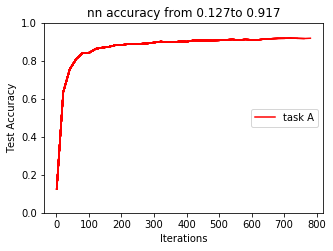

In [ ]:
# training 1st task
train_task(model, 800, 20, mnist, [mnist], x, y_, lams=[0])

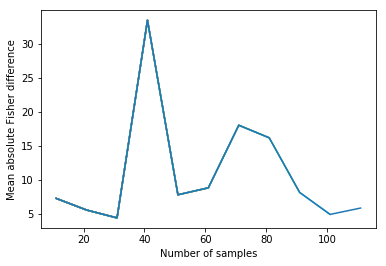

In [ ]:
# Fisher information
model.compute_fisher(mnist.validation.images, sess, num_samples=200, plot_diffs=True) # use validation set for Fisher computation

In [ ]:
F_row_mean = np.mean(model.F_accum[0], 1)
mnist_imshow(F_row_mean)
plt.title("W1 row-wise mean Fisher");

#### train on task B, test on tasks A and B

In [ ]:
# permuting mnist for 2nd task
mnist2 = permute_mnist(mnist)

plt.subplot(1,2,1)
mnist_imshow(mnist.train.images[5])
plt.title("original task image")
plt.subplot(1,2,2)
mnist_imshow(mnist2.train.images[5])
plt.title("new task image");

In [ ]:
# save current optimal weights
model.star()

In [ ]:
# training 2nd task
train_task(model, 800, 20, mnist2, [mnist, mnist2], x, y_, lams=[0, 15])

In [ ]:
# Fisher information for 2nd task
model.compute_fisher(mnist2.validation.images, sess, num_samples=200, plot_diffs=False)

In [ ]:
F_row_mean = np.mean(model.F_accum[0], 1)
mnist_imshow(F_row_mean)
plt.title("W1 row-wise mean Fisher");

#### train on task C, test on tasks A, B, and C

In [ ]:
# permuting mnist for 3rd task
mnist3 = permute_mnist(mnist,1)

In [ ]:
# save current optimal weights
model.star()

In [ ]:
# training 3rd task
train_task(model, 800, 20, mnist3, [mnist, mnist2,mnist3], x, y_, lams=[0, 15])
model.compute_fisher(mnist3.validation.images, sess, num_samples=200, plot_diffs=False)

In [ ]:
mnist4 = permute_mnist(mnist,2)
model.star()
train_task(model, 800, 20, mnist4, [mnist, mnist2,mnist3,mnist4], x, y_, lams=[0, 15])
model.compute_fisher(mnist4.validation.images, sess, num_samples=200, plot_diffs=False)

In [ ]:
mnist5 = permute_mnist(mnist,3)
model.star()
train_task(model, 800, 20, mnist5, [mnist, mnist2,mnist3,mnist4], x, y_, lams=[0, 15])
model.compute_fisher(mnist5.validation.images, sess, num_samples=200, plot_diffs=False)

In [ ]:
mnist6 = permute_mnist(mnist,4)
model.star()
train_task(model, 800, 20, mnist6, [mnist, mnist2,mnist3,mnist4], x, y_, lams=[0, 15])
model.compute_fisher(mnist6.validation.images, sess, num_samples=200, plot_diffs=False)

In [ ]:
mnist7 = permute_mnist(mnist,5)
model.star()
train_task(model, 800, 20, mnist7, [mnist, mnist2,mnist3,mnist4], x, y_, lams=[0, 15])
model.compute_fisher(mnist7.validation.images, sess, num_samples=200, plot_diffs=False)

In [ ]:
mnist8 = permute_mnist(mnist,6)
model.star()
train_task(model, 800, 20, mnist8, [mnist, mnist2,mnist3,mnist4], x, y_, lams=[0, 15])
model.compute_fisher(mnist8.validation.images, sess, num_samples=200, plot_diffs=False)

In [ ]:
model.star()
train_task(model, 800, 20, mnist, [mnist, mnist2,mnist3,mnist4], x, y_, lams=[0, 15])
model.compute_fisher(mnist.validation.images, sess, num_samples=200, plot_diffs=False)